In [11]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import colour
from random import randint as rint
import numpy as np
from colour import Color
import json
from data.planar.sample_planar import *

In [12]:
start, end = 3, 37
invalid_pos = []
for x in range(start, end + 1):
    for y in range(start, end + 1):
        s = [x,y]
        if is_colliding(np.array(s)):
            invalid_pos.append(s)

In [13]:
red = Color('blue')
# red_rgb = np.array(Color('red').rgb)
# blue_rgb = np.array(Color('blue').rgb)
colors = list(red.range_to(Color("red"),36))
colors_rgb = [color.rgb for color in colors]
# print (colors_rgb)

In [14]:
def random_gradient():
    img = Image.new("RGB", (width,height), "#FFFFFF")
    draw = ImageDraw.Draw(img)
    
    for i, color in zip(range(start, end+1), colors_rgb):
        r1, g1, b1 = color[0] * 255., color[1] * 255., color[2] * 255.
        draw.line((i,start,i,end), fill=(int(r1), int(g1), int(b1)))
        
    # obstacles as white
#     for y, x in obstacles_center:
#         draw.rectangle(((x - r, y - r), (x + r, y + r)), fill="white")

    img_arr = np.array(img)
    for x, y in invalid_pos:
        img_arr[x, y] = 255.
    return img_arr / 255., img

In [15]:
img_arr, img = random_gradient()

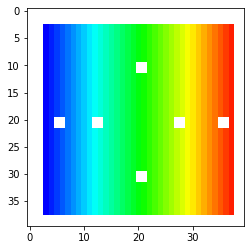

In [16]:
plt.imshow(img_arr)
# plt.axis('off')
plt.show()

In [17]:
img_scaled = Image.new("RGB", (width * 10,height*10), "#FFFFFF")
draw = ImageDraw.Draw(img_scaled)
for y in range(start, end + 1):
    for x in range(start, end + 1):
        if [y, x] in invalid_pos:
            continue
        else:
            x_scaled, y_scaled = x * 10, y * 10
            draw.ellipse((x_scaled-2, y_scaled-2, x_scaled+2, y_scaled+2), fill = img.getpixel((x,y)))
img_scaled.save('map.png', 'PNG')
img_arr_scaled = np.array(img_scaled) / 255.

In [18]:
import torch
from pcc_model import PCC
import os

Drawing map scheduling_result/planar/log_armo_1


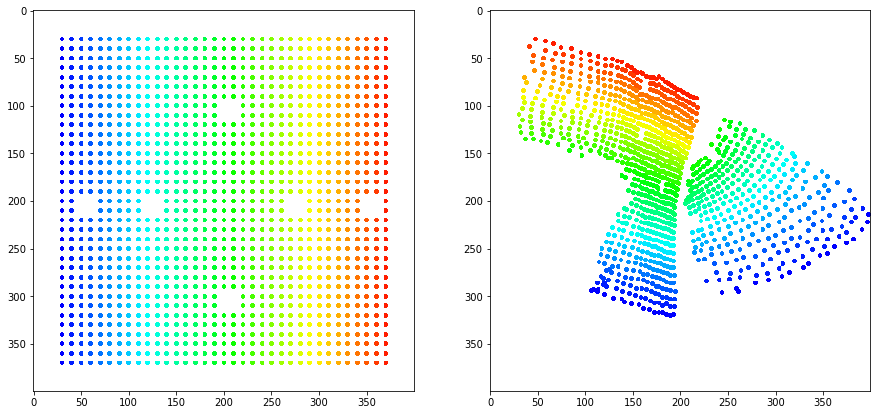

Drawing map scheduling_result/planar/log_armo_10


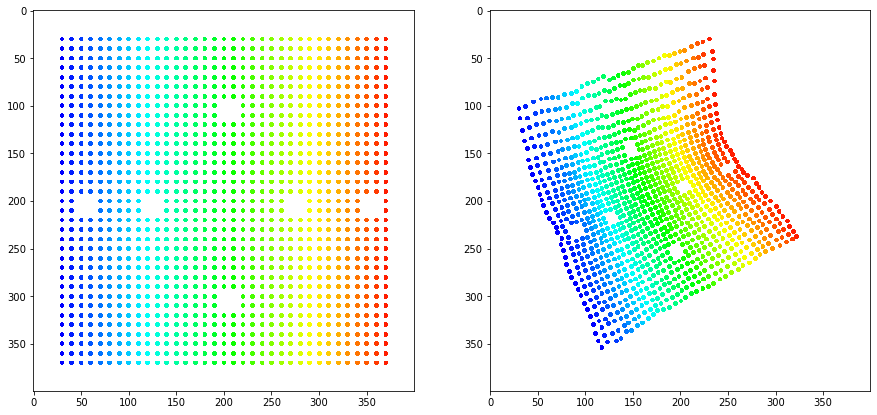

Drawing map scheduling_result/planar/log_armo_2


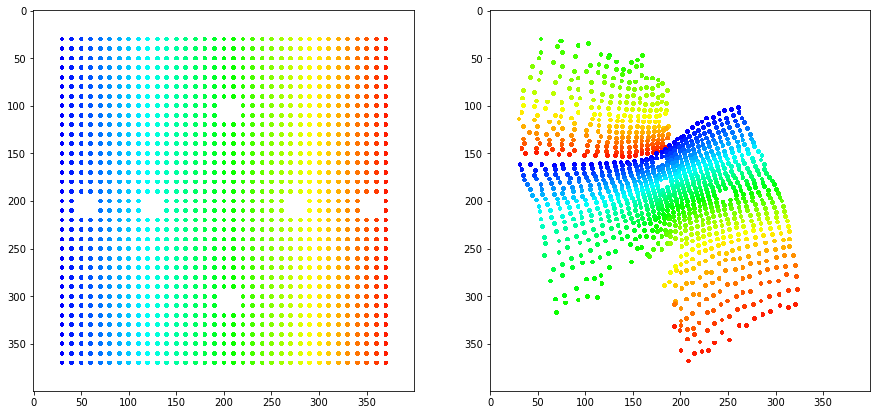

Drawing map scheduling_result/planar/log_armo_3


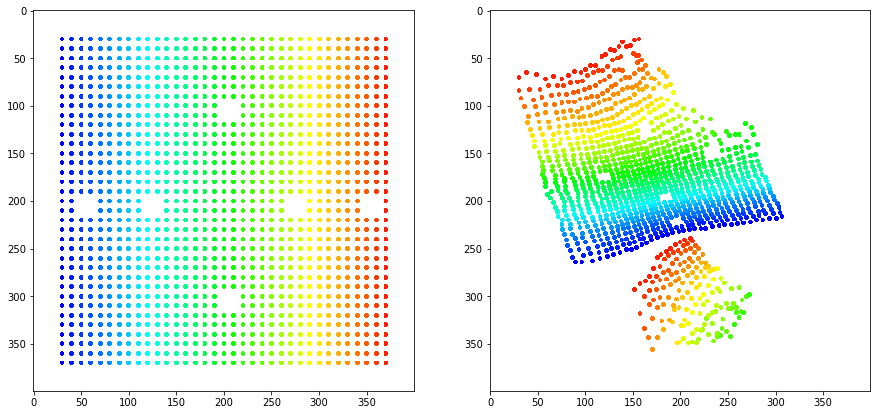

Drawing map scheduling_result/planar/log_armo_4


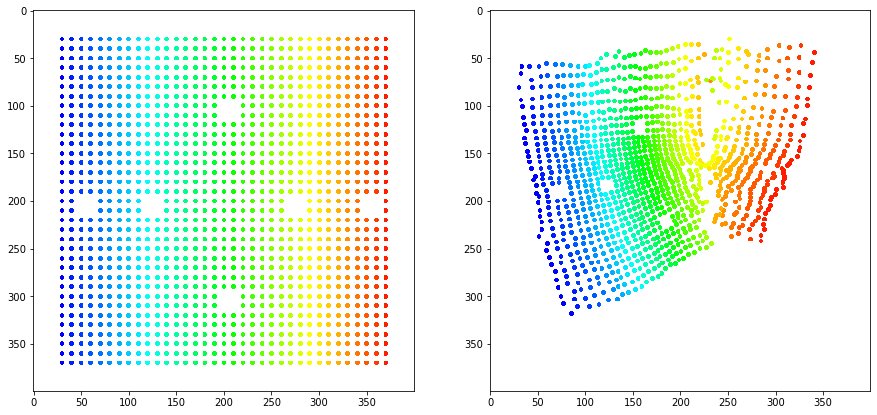

Drawing map scheduling_result/planar/log_armo_5


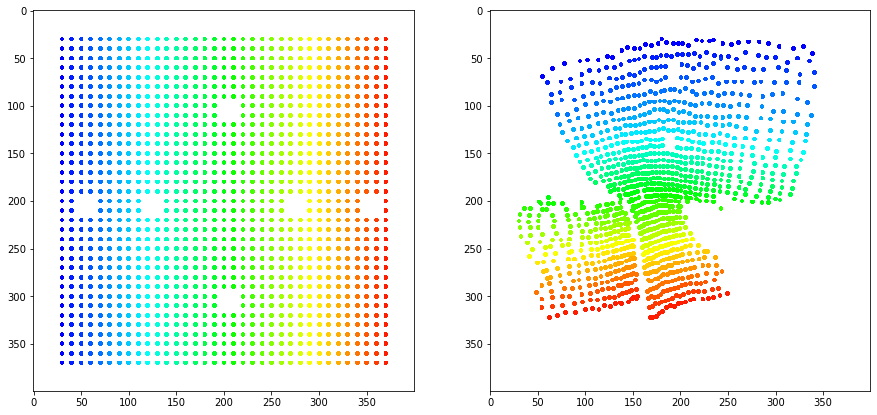

Drawing map scheduling_result/planar/log_armo_7


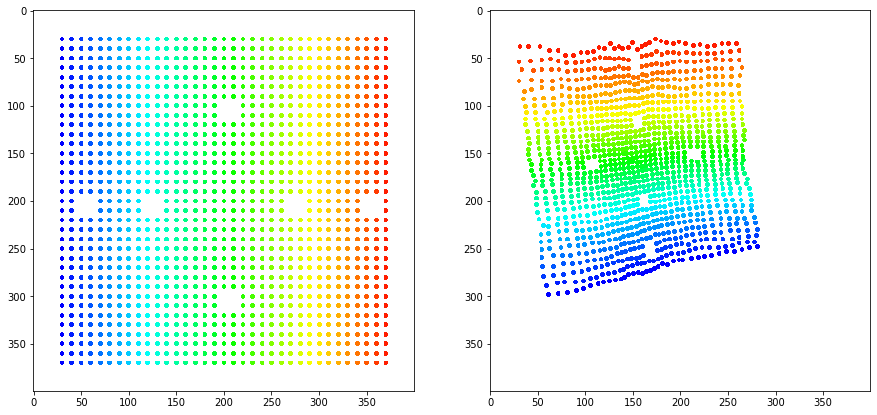

Drawing map scheduling_result/planar/log_armo_8


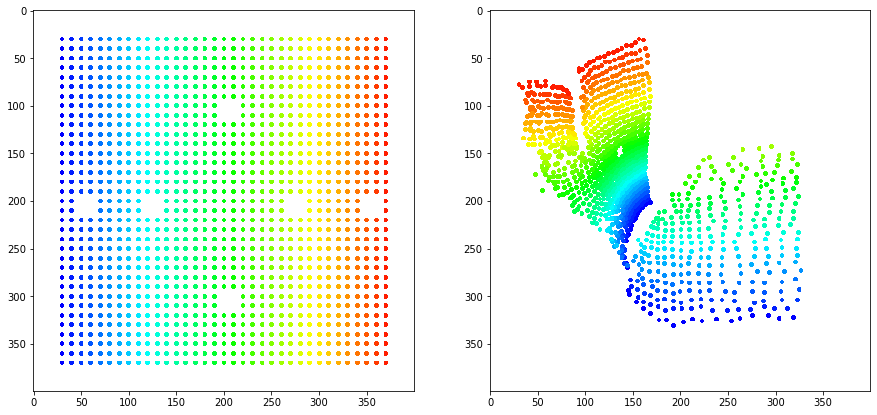

Drawing map scheduling_result/planar/log_armo_9


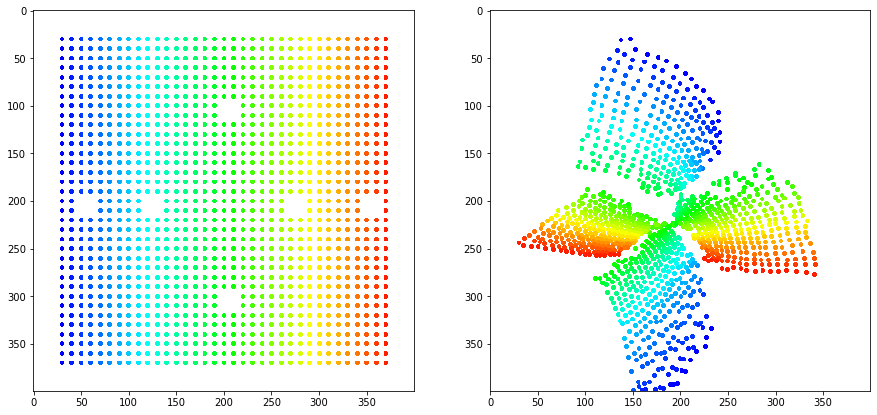

Drawing map scheduling_result/planar/log_no_armo_1


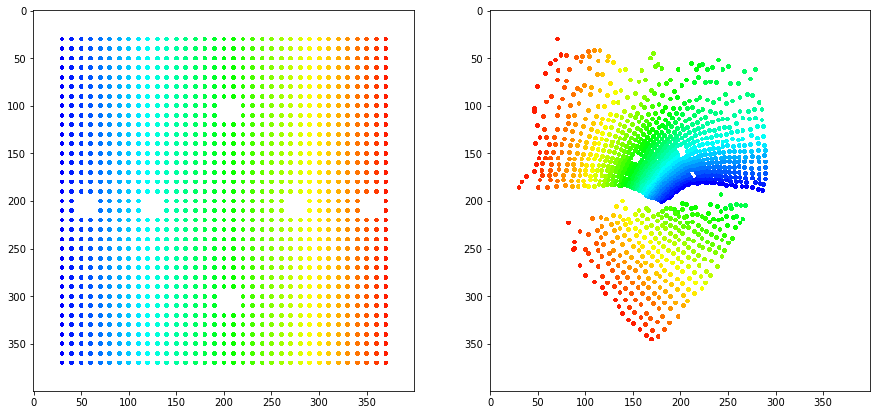

Drawing map scheduling_result/planar/log_no_armo_10


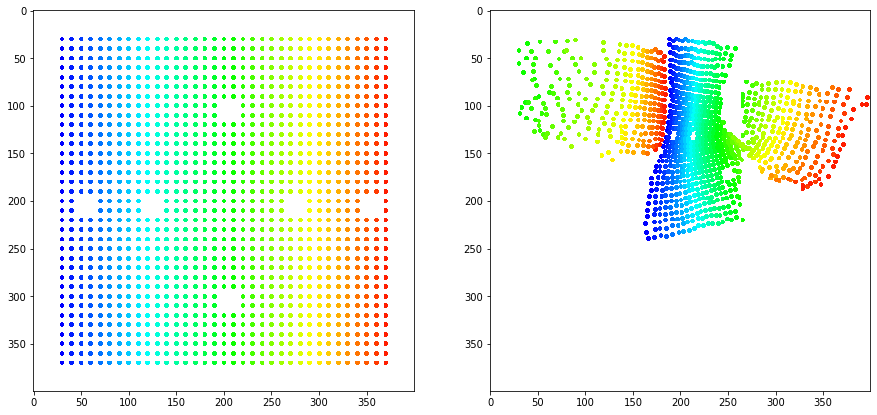

Drawing map scheduling_result/planar/log_no_armo_2


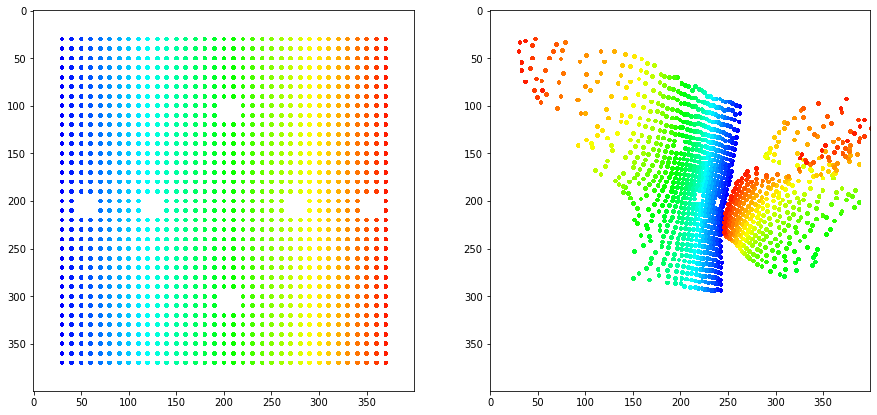

Drawing map scheduling_result/planar/log_no_armo_3


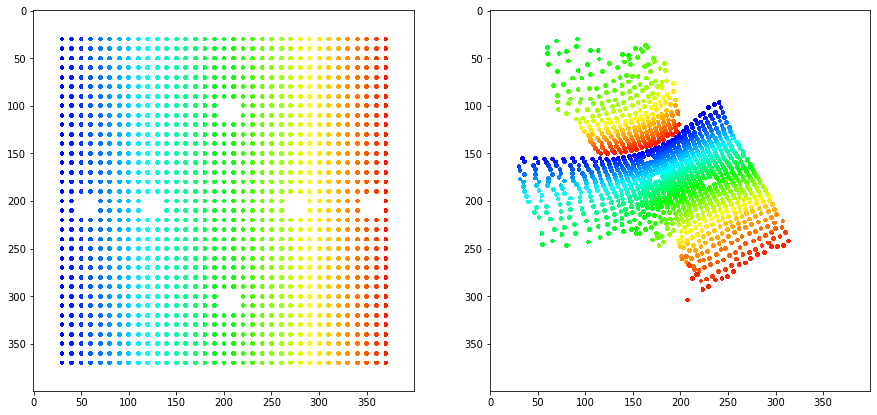

Drawing map scheduling_result/planar/log_no_armo_4


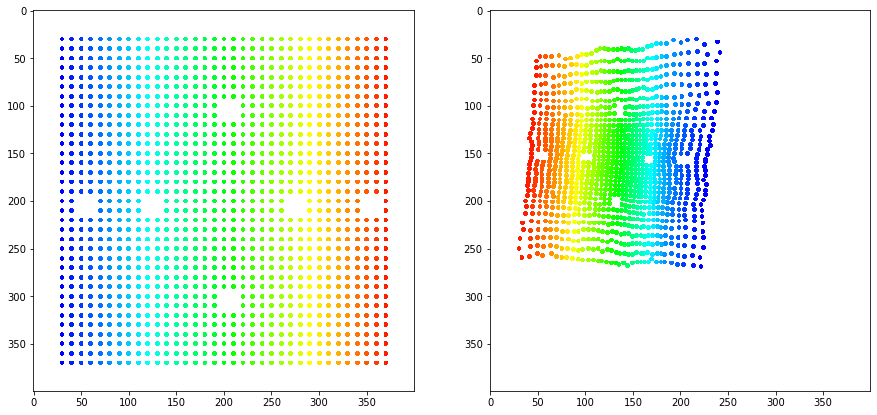

Drawing map scheduling_result/planar/log_no_armo_5


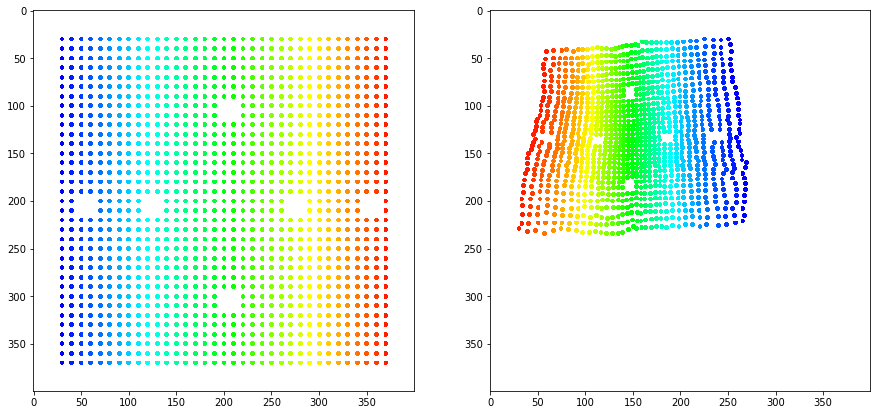

Drawing map scheduling_result/planar/log_no_armo_6


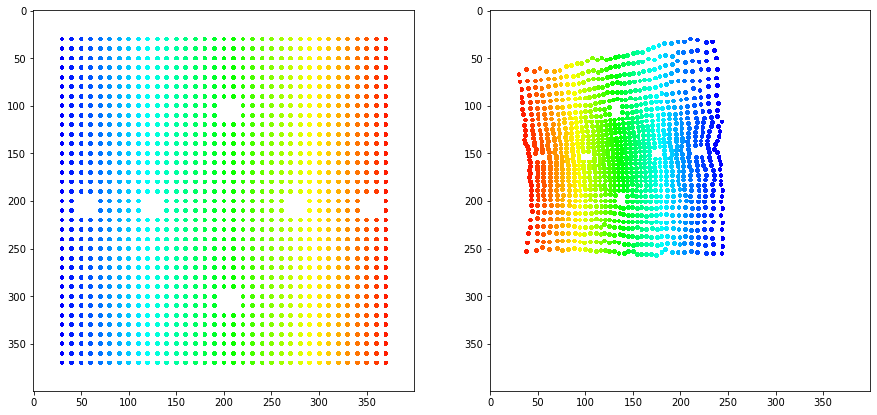

Drawing map scheduling_result/planar/log_no_armo_7


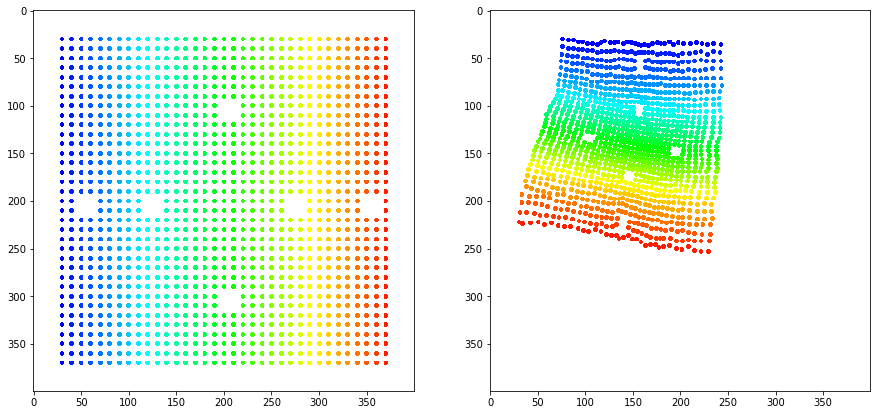

Drawing map scheduling_result/planar/log_no_armo_8


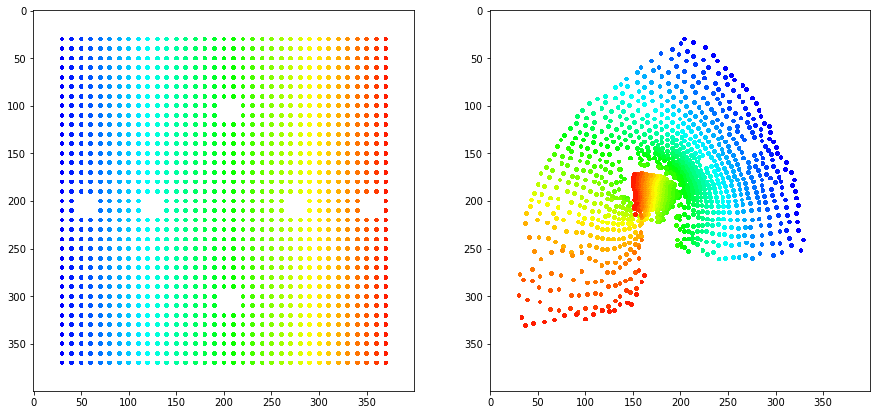

Drawing map scheduling_result/planar/log_no_armo_9


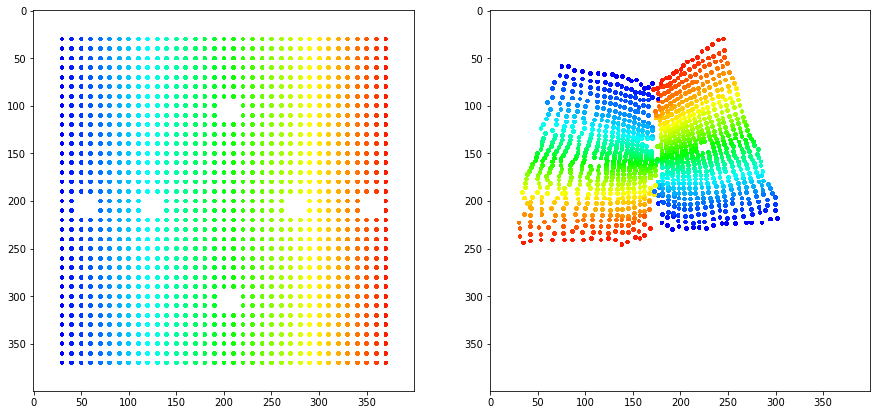

Drawing map scheduling_result/planar/log_no_armo_variant_1
Drawing map scheduling_result/planar/log_no_armo_variant_2
Drawing map scheduling_result/planar/log_no_armo_variant_3
Drawing map scheduling_result/planar/log_no_armo_variant_4
Drawing map scheduling_result/planar/log_no_armo_variant_5


In [19]:
folder = 'scheduling_result/planar'
log_folders = [os.path.join(folder, dI) for dI in os.listdir(folder) if os.path.isdir(os.path.join(folder,dI))]
log_folders.sort()
# model = PCC(1600,2,2,'planar').cuda(0)

for log in log_folders:
    with open(log + '/settings', 'r') as f:
        settings = json.load(f)
    armotized = settings['armotized']
    model = PCC(armotized,1600,2,2,'planar').cuda(0)
    print ('Drawing map ' + log)
    if not os.path.exists(log + '/model_5000'):
        continue
    model.load_state_dict(torch.load(log + '/model_5000'))
    model.eval()
    
    # compute latent z
    all_z = []
    for x in range(start, end + 1):
        for y in range(start, end + 1):
            s = np.array([x,y])
            if [x,y] in invalid_pos:
                all_z.append(np.zeros(2))
            else:
                obs = render(s)
                with torch.no_grad():
                    obs = torch.Tensor(render(s)).unsqueeze(0).view(-1,1600).double().cuda(0)
                    mu, sigma = model.encode(obs)
                z = mu.squeeze().cpu().numpy()
                all_z.append(np.copy(z))
    all_z = np.array(all_z)

    # normalize and scale to plot
    z_min = np.min(all_z, axis = 0)
    all_z = np.round(15 * (all_z - z_min) + 30).astype(np.int)
    
    # compute the average difference between 2 consecutive points
#     count = 0
#     diff = 0.0
#     for i in range(0, all_z.shape[0] - 1):
#         diff += np.sum(np.abs(all_z[i] - all_z[i+1]))
#         count += 1
#     avg_diff = diff / count
#     print (avg_diff)

    # count the number of distinct latent representations
#     count = 0
#     d = {}
#     for z in all_z:
#         z_tuple = tuple(z)
#         if z_tuple not in d:
#             count += 1
#             d[z_tuple] = 0
#     print ('Log: ' + log + ', ' + str(count))
#     z_max = np.max(all_z, axis = 0)
#     z_min = np.min(all_z, axis = 0)
#     print ('Max: ' + str(z_max) + ', Min: ' + str(z_min))

    # plot
    latent_map = {}
    i = 0
    for x in range(start, end + 1):
        for y in range(start, end + 1):
            latent_map[(x,y)] = all_z[i]
            i += 1
            
    img_latent = Image.new("RGB", (width * 10, height * 10), "#FFFFFF")
    draw = ImageDraw.Draw(img_latent)
    for k in latent_map:
        x, y = k
        if [x, y] in invalid_pos:
            continue
        else:
            x_scaled, y_scaled = latent_map[k][1], latent_map[k][0]
            draw.ellipse((x_scaled-2, y_scaled-2, x_scaled+2, y_scaled+2), fill = img.getpixel((y, x)))
    img_latent_scaled = np.array(img_latent) / 255.

    f, axarr = plt.subplots(1,2, figsize=(15,15))
    axarr[0].imshow(img_arr_scaled)
    axarr[1].imshow(img_latent_scaled)
    latent_map_dir = 'latent_map/'
    if not os.path.exists(latent_map_dir):
        os.makedirs(latent_map_dir)
    f.savefig(latent_map_dir + os.path.basename(os.path.normpath(log)) + '.png',
              bbox_inches="tight")
    plt.show()

In [ ]:
count = 0
sum_diff_x = 0.0
sum_diff_y = 0.0
for i in range(0, all_z.shape[0] - 1):
    sum_diff_x += np.abs(all_z[i][0] - all_z[i+1][0])
    sum_diff_y += np.abs(all_z[i][1] - all_z[i+1][1])
    count += 1
avg_diff_x = sum_diff_x / count
avg_diff_y = sum_diff_y / count
1 / avg_diff_x, 1 / avg_diff_y